### 优化器的概念
PyTorch 中的优化器是用于管理并更新模型中可学习参数的值，使得模型输出更加接近真实标签。


### optimizer 的属性
```python
class Optimizer(object):
    def __init__(self, params, defaults):        
        self.defaults = defaults
        self.state = defaultdict(dict)
        self.param_groups = []
```
```
主要有 3 个属性
    defaults：优化器的超参数，如 weight_decay，momentum
    state：参数的缓存，如 momentum 中需要用到前几次的梯度，就缓存在这个变量中
    param_groups：管理的参数组，是一个 list，其中每个元素是字典，包括 momentum、lr、weight_decay、params 等。
    _step_count：记录更新 次数，在学习率调整中使用

### optimizer 的方法
#### zero_grad()：清空所管理参数的梯度。由于 PyTorch 的特性是张量的梯度不自动清零，因此每次反向传播之后都需要清空梯度。代码如下
```python
def zero_grad(self):
    r"""Clears the gradients of all optimized :class:`torch.Tensor` s."""
    for group in self.param_groups:
        for p in group['params']:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()
```
#### step()：执行一步梯度更新
#### add_param_group()：添加参数组，主要代码如下：
```python
def add_param_group(self, param_group):
    params = param_group['params']
    if isinstance(params, torch.Tensor):
        param_group['params'] = [params]
    ...
    self.param_groups.append(param_group)
```
#### state_dict()：获取优化器当前状态信息字典
#### load_state_dict()：加载状态信息字典，包括 state 、momentum_buffer 和 param_groups。主要用于模型的断点续训练。我们可以在每隔 50 个 epoch 就保存模型的 state_dict 到硬盘，在意外终止训练时，可以继续加载上次保存的状态，继续训练。

```python
def state_dict(self):
    r"""Returns the state of the optimizer as a :class:`dict`.
    ...
    return {
    'state': packed_state,
    'param_groups': param_groups,
    }
```

### step()
张量 weight 的形状为$2 \times 2$，并设置梯度为 1，把 weight 传进优化器，学习率设置为 1，执行optimizer.step()更新梯度，也就是所有的张量都减去 1

In [55]:
import torch
from torch import optim
weight = torch.randn((2, 2), requires_grad=True)
weight.grad = torch.ones((2, 2))

optimizer = optim.SGD([weight], lr=0.1)

print("weight before step:{}".format(weight.data))
optimizer.step()        # 修改lr=1, 0.1观察结果
print("weight after step:{}".format(weight.data))

weight before step:tensor([[-0.0388, -1.8812],
        [ 1.0339,  1.0047]])
weight after step:tensor([[-0.1388, -1.9812],
        [ 0.9339,  0.9047]])


### zero_grad()

In [56]:
print("weight before step:{}".format(weight.data))
optimizer.step()        # 修改lr=1 0.1观察结果
print("weight after step:{}".format(weight.data))

print("weight in optimizer:{}\nweight in weight:{}\n".format(id(optimizer.param_groups[0]['params'][0]), id(weight)))

print("weight.grad is {}\n".format(weight.grad))

optimizer.zero_grad()
print("after optimizer.zero_grad(), weight.grad is\n{}".format(weight.grad))

weight before step:tensor([[-0.1388, -1.9812],
        [ 0.9339,  0.9047]])
weight after step:tensor([[-0.2388, -2.0812],
        [ 0.8339,  0.8047]])
weight in optimizer:4400857472
weight in weight:4400857472

weight.grad is tensor([[1., 1.],
        [1., 1.]])

after optimizer.zero_grad(), weight.grad is
tensor([[0., 0.],
        [0., 0.]])


### add_param_group()

In [57]:
# 向优化器中添加一组参数
print("optimizer.param_groups is\n{}".format(optimizer.param_groups))

w2 = torch.randn((3, 3), requires_grad=True)

optimizer.add_param_group({"params": w2, 'lr': 0.0001})
print("optimizer.param_groups is\n{}".format(optimizer.param_groups))

optimizer.param_groups is
[{'params': [tensor([[-0.2388, -2.0812],
        [ 0.8339,  0.8047]], requires_grad=True)], 'lr': 0.1, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False}]
optimizer.param_groups is
[{'params': [tensor([[-0.2388, -2.0812],
        [ 0.8339,  0.8047]], requires_grad=True)], 'lr': 0.1, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False}, {'params': [tensor([[ 1.7357, -0.1898,  0.3908],
        [-0.7719, -0.1099, -0.6309],
        [-0.8644,  1.0370, -0.4380]], requires_grad=True)], 'lr': 0.0001, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False}]


### state_dict()

In [58]:
# 首先进行 10 次反向传播更新，然后对比 state_dict 的变化。可以使用torch.save()把 state_dict 保存到 pkl 文件中。
import os

optimizer = optim.SGD([weight], lr=0.1, momentum=0.9)
opt_state_dict = optimizer.state_dict()

print("state_dict before step:\n", opt_state_dict)

for i in range(10):
    optimizer.step()

print("state_dict after step:\n", optimizer.state_dict())

torch.save(optimizer.state_dict(), os.path.join('', "optimizer_state_dict.pkl"))

state_dict before step:
 {'state': {}, 'param_groups': [{'lr': 0.1, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'params': [0]}]}
state_dict after step:
 {'state': {0: {'momentum_buffer': tensor([[0., 0.],
        [0., 0.]])}}, 'param_groups': [{'lr': 0.1, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'params': [0]}]}


### load_state_dict()

In [59]:
# 上面保存了 state_dict 之后，可以先使用torch.load()把加载到内存中，然后再使用load_state_dict()加载到模型中，继续训练。
optimizer = optim.SGD([weight], lr=0.1, momentum=0.9)
state_dict = torch.load(os.path.join('', "optimizer_state_dict.pkl"))

print("state_dict before load state:\n", optimizer.state_dict())
optimizer.load_state_dict(state_dict)
print("state_dict after load state:\n", optimizer.state_dict())

state_dict before load state:
 {'state': {}, 'param_groups': [{'lr': 0.1, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'params': [0]}]}
state_dict after load state:
 {'state': {0: {'momentum_buffer': tensor([[0., 0.],
        [0., 0.]])}}, 'param_groups': [{'lr': 0.1, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'params': [0]}]}


### 学习率

In [60]:
def func(x_t):
    """
    y = (2x)^2 = 4*x^2      dy/dx = 8x
    """
    return torch.pow(2*x_t, 2)

In [61]:
# import matplotlib.pyplot as plt

# iter_rec, loss_rec, x_rec = list(), list(), list()

# lr = 0.01    # /1. /.5 /.2 /.1 /.125
# max_iteration = 20   # /1. 4     /.5 4   /.2 20 200
# # init
# x = torch.tensor([2.], requires_grad=True)

# for i in range(max_iteration):
#     y = func(x)
#     y.backward()

#     print("Iter:{}, X:{:8}, X.grad:{:8}, loss:{:10}".format(
#     i, x.detach().numpy()[0], x.grad.detach().numpy()[0], y.item()))

#     x_rec.append(x.item())

#     x.data.sub_(lr * x.grad)    # x -= x.grad  数学表达式意义:  x = x - x.grad    # 0.5 0.2 0.1 0.125
#     x.grad.zero_()

#     iter_rec.append(i)
#     loss_rec.append(y)

# plt.subplot(121)
# plt.plot(iter_rec, loss_rec, '-ro')

# plt.xlabel("Iteration")
# plt.ylabel("Loss value")

# x_t = torch.linspace(-3, 3, 100)
# y = func(x_t)
# plt.subplot(122).plot(x_t.numpy(), y.numpy(), label="y = 4*x^2")
# plt.grid()
# y_rec = [func(torch.tensor(i)).item() for i in x_rec]
# plt.subplot(122).plot(x_rec, y_rec, '-ro')
# plt.legend()
# plt.show()

### momentum 动量

```
momentum 动量的更新方法，不仅考虑当前的梯度，还会结合前面的梯度

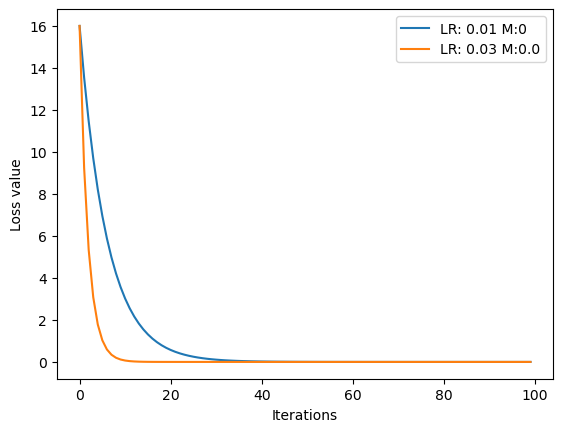

In [62]:
    def func(x):
        return torch.pow(2*x, 2)    # y = (2x)^2 = 4*x^2        dy/dx = 8x

    iteration = 100
    m = 0     # .9 .63

    lr_list = [0.01, 0.03]

    momentum_list = list()
    loss_rec = [[] for l in range(len(lr_list))]
    iter_rec = list()

    for i, lr in enumerate(lr_list):
        x = torch.tensor([2.], requires_grad=True)

        momentum = 0. if lr == 0.03 else m
        momentum_list.append(momentum)

        optimizer = optim.SGD([x], lr=lr, momentum=momentum)

        for iter in range(iteration):

            y = func(x)
            y.backward()

            optimizer.step()
            optimizer.zero_grad()

            loss_rec[i].append(y.item())

    for i, loss_r in enumerate(loss_rec):
        plt.plot(range(len(loss_r)), loss_r, label="LR: {} M:{}".format(lr_list[i], momentum_list[i]))
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Loss value')
    plt.show()

### PyTroch 提供的 10 种优化器

### optim.SGD
```python
optim.SGD(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False
```
```
主要参数：
    params：管理的参数组
    lr：初始学习率
    momentum：动量系数$\beta$
    weight_decay：L2 正则化系数
    nesterov：是否采用 NAG

### optim.Adagrad
自适应学习率梯度下降法

### optim.RMSprop
Adagrad 的改进

### optim.Adadelta

### optim.Adam
RMSProp 集合 Momentum，这个是目前最常用的优化器，因为它可以使用较大的初始学习率

### optim.Adamax
Adam 增加学习率上限

### optim.SparseAdam
稀疏版的 Adam

### optim.ASGD
随机平均梯度下降

### optim.Rprop
弹性反向传播，这种优化器通常是在所有样本都一起训练，也就是 batchsize 为全部样本时使用。

### optim.LBFGS
BFGS 在内存上的改进